# Lending Club Note Status Prediction

###### Table of contents
1. [Introduction](#introduction)
2. [Data](#data)
    1. [Historical Data](#Historical Data)
    2. [Recent List Loan Data](#Recent List Loan Data)
    3. [Feature Field Match](#Feature Field Match)
3. [Feature Selection](#Feature Selection)
    1. [Remove Features with Too Muuch Missing Values](#Remove Features with Too Muuch Missing Values)
    2. [Hypothesis Test](#Hypothesis Test)
    3. [Remove Highly-Correlated Features](#Remove Highly-Correlated Features)
    4. [Plot The Statistics of Features](#Plot The Statistics of Features)
4. [Feature Engineering](#Feature Engineering)
    1. [Label Encoding](#Label Encoding)
    2. [One-hot Encoding](#One-hot Encoding)
    3. [Train/Test data split](#Train/Test data split)
    4. [Imputing missing value](#Imputing missing value)
    5. [Feature Scaling ](#Feature Scaling)
5. [Modeling](#Modeling)
    1. [Linear logistic regression with SGD](#Linear logistic regression with SGD)
    2. [Random Forest](#Random Forest)
    3. [Gradient Boosting Tree](#Gradient Boosting Tree)
6. [Model Comparison](#Model Comparison)

In [229]:
#This code is modifed based on https://github.com/yanxiali/Predicting-Default-Clients-of-Lending-Club-Loans/blob/master/LC_Loan_full.ipynb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import json
from datetime import datetime
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer, roc_auc_score,accuracy_score, roc_curve
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## 1. Introduction <a name="introduction"></a>
LendingClub is the world's largest peer-to-peer lending platform. The company enables borrowers to create personal loans between \$1,000 and \$40,000. The investors can search and browse the loan listings on LendingClub website and select loans that they want to invest based on the information supplied about the borrower. Investor make money from interest. LendingClub makes money by charging borrowers an origination fee and investor a service fee. <br>

This project is to use the historical loan data from LendingClub to build a model that can predict the loan status (whether or not the loan will be default or fully paid). The model also finds the most important factors which impact the prediction from the user information provided by the borrowers. The Lending Club investors can use these results to make better-informed decisions on note choice.

## 2. Data <a name="data"></a>
In this project, I mainly worked on LendingClub historical data from 2007 to 2018 on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). The dataset is 1.55 GB of Size including 2260701 loans and each of which has 150 associated features.

On the other hand, the historical data include some features that are not immediately available when the borrowers create the personcal loan. Thus, I used the latest data of the recently listed loans through LendingClub API. Only the features included in the listed loans would be used for model prediction, and other features in the historical data will be excluded. I will match the feature field between the two datasets.


### 2.1 Historical Data <a name="Historical Data"></a>

In [4]:
#file path
file_path = '../../../../../../01_Data/02_fintech/'
folders = os.listdir(file_path)
folders = [f for f in folders if 'xlsx' not in f]
acc_folder = file_path + [f for f in folders if 'accepted' in f][0]
accepted_fn = acc_folder + '/' + os.listdir(acc_folder)[0]

In [10]:
#read the historical data
acc_df = pd.read_csv(accepted_fn)
acc_df.shape

(2260701, 151)

In [19]:
#find out the good loans in the historical ata
paid_status = ['Fully Paid',  'Does not meet the credit policy. Status:Fully Paid']
default_status = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

In [20]:
#all the data useful for model training
hst_df = acc_df[acc_df['loan_status'].isin(default_status) | acc_df['loan_status'].isin(paid_status)]

In [22]:
#check the historical data feature filed
[col for col in sorted(hst_df.columns)]

['acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_

In [30]:
hst_df.shape

(1348099, 151)

The historical data have 1348099 useful personal loan data, and each entry includes 150 associated features and one feature indicating the loan status.

### 2.2 Recent List Loan Data <a name="Recent List Loan Data"></a>

In [ ]:
#use LC API to download the latest loan application data to select the features
api_key = open('apikey.txt', 'r').read().split('\n')
headers = {'Authorization': api_key[0]}
url = 'https://api.lendingclub.com/api/investor/v1/loans/listing'
r = requests.get(url, headers=headers)

data = r.json()
myData = data['loans']

app_file = file_path+'testdata.txt'
with open(app_file, 'w') as outfile:
    json.dump(myData, outfile)

In [12]:
app_file = file_path+'testdata.txt'
app_df = pd.read_json(app_file, 'r')

In [13]:
app_df.shape

(141, 103)

In [14]:
[col for col in sorted(app_df.columns)]

['accNowDelinq',
 'accOpenPast24Mths',
 'acceptD',
 'addrState',
 'addrZip',
 'allUtil',
 'annualInc',
 'annualIncJoint',
 'applicationType',
 'avgCurBal',
 'bcOpenToBuy',
 'bcUtil',
 'chargeoffWithin12Mths',
 'collections12MthsExMed',
 'creditPullD',
 'delinq2Yrs',
 'delinqAmnt',
 'desc',
 'dti',
 'dtiJoint',
 'earliestCrLine',
 'empLength',
 'empTitle',
 'expD',
 'expDefaultRate',
 'ficoRangeHigh',
 'ficoRangeLow',
 'fundedAmount',
 'grade',
 'homeOwnership',
 'iLUtil',
 'id',
 'ilsExpD',
 'initialListStatus',
 'inqFi',
 'inqLast12m',
 'inqLast6Mths',
 'installment',
 'intRate',
 'investorCount',
 'isIncV',
 'isIncVJoint',
 'listD',
 'loanAmount',
 'maxBalBc',
 'memberId',
 'moSinOldIlAcct',
 'moSinOldRevTlOp',
 'moSinRcntRevTlOp',
 'moSinRcntTl',
 'mortAcc',
 'mthsSinceLastDelinq',
 'mthsSinceLastMajorDerog',
 'mthsSinceLastRecord',
 'mthsSinceRcntIl',
 'mthsSinceRecentBc',
 'mthsSinceRecentBcDlq',
 'mthsSinceRecentInq',
 'mthsSinceRecentRevolDelinq',
 'numAcctsEver120Ppd',
 'numAct

the application data includes 103 features, while the historical data include 151 features. <br>
some of the features in the historical data were not proivided or not availabe at the beginning of loan application.<br>
data field matching is needed

### 2.3 Feature Field Match <a name="Feature Field Match"></a>
From previous sections, I noticed that the feature name format of historical data is different from the recently listed loan data. For the recent data, I will change the upper case characters to lower characters. For the historical data, I'll remove the underscore '_' from the feature names.

In [17]:
#change the application data fields to lower case
app_df = app_df.rename(columns = lambda x:x.lower())
[col for col in sorted(app_df.columns)]

['acceptd',
 'accnowdelinq',
 'accopenpast24mths',
 'addrstate',
 'addrzip',
 'allutil',
 'annualinc',
 'annualincjoint',
 'applicationtype',
 'avgcurbal',
 'bcopentobuy',
 'bcutil',
 'chargeoffwithin12mths',
 'collections12mthsexmed',
 'creditpulld',
 'delinq2yrs',
 'delinqamnt',
 'desc',
 'dti',
 'dtijoint',
 'earliestcrline',
 'emplength',
 'emptitle',
 'expd',
 'expdefaultrate',
 'ficorangehigh',
 'ficorangelow',
 'fundedamount',
 'grade',
 'homeownership',
 'id',
 'ilsexpd',
 'ilutil',
 'initialliststatus',
 'inqfi',
 'inqlast12m',
 'inqlast6mths',
 'installment',
 'intrate',
 'investorcount',
 'isincv',
 'isincvjoint',
 'listd',
 'loanamount',
 'maxbalbc',
 'memberid',
 'mortacc',
 'mosinoldilacct',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mosinrcnttl',
 'mthssincelastdelinq',
 'mthssincelastmajorderog',
 'mthssincelastrecord',
 'mthssincercntil',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'mthssincerecentinq',
 'mthssincerecentrevoldelinq',
 'numacctsever120ppd',
 'numact

In [23]:
#remove the underscore in historical data columns
hst_df = hst_df.rename(columns = lambda x: x.replace("_", ""))
[col for col in sorted(hst_df.columns)]

['accnowdelinq',
 'accopenpast24mths',
 'addrstate',
 'allutil',
 'annualinc',
 'annualincjoint',
 'applicationtype',
 'avgcurbal',
 'bcopentobuy',
 'bcutil',
 'chargeoffwithin12mths',
 'collectionrecoveryfee',
 'collections12mthsexmed',
 'debtsettlementflag',
 'debtsettlementflagdate',
 'deferralterm',
 'delinq2yrs',
 'delinqamnt',
 'desc',
 'disbursementmethod',
 'dti',
 'dtijoint',
 'earliestcrline',
 'emplength',
 'emptitle',
 'ficorangehigh',
 'ficorangelow',
 'fundedamnt',
 'fundedamntinv',
 'grade',
 'hardshipamount',
 'hardshipdpd',
 'hardshipenddate',
 'hardshipflag',
 'hardshiplastpaymentamount',
 'hardshiplength',
 'hardshiploanstatus',
 'hardshippayoffbalanceamount',
 'hardshipreason',
 'hardshipstartdate',
 'hardshipstatus',
 'hardshiptype',
 'homeownership',
 'id',
 'ilutil',
 'initialliststatus',
 'inqfi',
 'inqlast12m',
 'inqlast6mths',
 'installment',
 'intrate',
 'issued',
 'lastcreditpulld',
 'lastficorangehigh',
 'lastficorangelow',
 'lastpymntamnt',
 'lastpymntd',


In [24]:
#find out the different fields and match them
hst_diff = set(hst_df.columns) - set(app_df.columns)
app_diff = set(app_df.columns) - set(hst_df.columns)

In [25]:
#some feature names are different but actually the same thing
name_change = {'addrzip':'zipcode',
              'creditpulld':'lastcreditpulld',
              'fundedamount':'fundedamnt',
              'isincv':'verificationstatus',
              'isincvjoint':'verificationstatusjoint',
              'loanamount':'loanamnt',
              'numacctsever120ppd':'numacctsever120pd',
              }
app_df = app_df.rename(columns = name_change)

In [26]:
app_diff = set(app_df.columns) - set(hst_df.columns)

In [28]:
same_col = set(hst_df.columns)&set(app_df.columns)
same_col.add('loanstatus')

In [29]:
hst_match_df = hst_df[same_col]
hst_match_df.shape

(1348099, 94)

After feature field matching, we excluded the features not avaiable in the recent listed loan data. There are 93 features in the historical data that can be used for model building.

## 3. Feature Selection <a name="Feature Selection"></a>
After feature field matching, there are 93 features left. I'll perform the following steps for feature selection. <br> 
1. I'll drop the features with 50% of the data missing
2. Split the data in to 'Fully paid' and 'Charged off' group, and use hypothesis test to compare the distributions between the two groups
3. Remove the highly correlated features

### 3.1 Remove Features with Too Much Missing Values <a name="Remove Features with Too Muuch Missing Values"></a>

In [32]:
# define a function to visualize the features with missing values, and the percentage of total values, and the data type
def missing_values_table(df):
    #total missing value
    mis_val = df.isnull().sum()
    #percentage of the missing values
    mis_val_percent = 100*mis_val/len(df)
    mis_val_type = df.dtypes
    #combine the results to a table
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis = 1)
    #name the column
    mis_val_table_rename_col = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values', 2: 'Type'})
    #sort the table by percentage of missing descending
    mis_val_table_rename_col = mis_val_table_rename_col[mis_val_table_rename_col.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)
    
    #prnit 
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_rename_col.shape[0])+" column that have missing values.")
    #return the dataframe with missing information
    return mis_val_table_rename_col

In [33]:
missing_values_table(hst_match_df)

Your selected dataframe has 94 columns.
There are 76 column that have missing values.


Missing Values  % of Total Values     Type
memberid                           1348099              100.0  float64
verificationstatusjoint            1322498               98.1   object
dtijoint                           1322296               98.1  float64
annualincjoint                     1322293               98.1  float64
desc                               1222144               90.7   object
mthssincelastrecord                1118675               83.0  float64
mthssincerecentbcdlq               1029070               76.3  float64
mthssincelastmajorderog             994342               73.8  float64
mthssincerecentrevoldelinq          898123               66.6  float64
ilutil                              883052               65.5  float64
mthssincercntil                     824680               61.2  float64
allutil                             810516               60.1  float64
openacc6m                           810464               60.1  float64
totalcutl                           810464               60.1  float64
inqlast12m                          810464               60.1  float64
inqfi                               810463               60.1  float64
maxbalbc                            810463               60.1  float64
openrv24m                           810463               60.1  float64
openil24m                           810463               60.1  float64
openil12m                           810463               60.1  float64
totalbalil                          810463               60.1  float64
openrv12m                           810463               60.1  float64
mthssincelastdelinq                 679960               50.4  float64
mthssincerecentinq                  176822               13.1  float64
numtl120dpd2m                       120152                8.9  float64
mosinoldilacct                      108325                8.0  float64
emptitle                             85950                6.4   object
emplength                            78550                5.8   object
pcttlnvrdlq                          70430                5.2  float64
avgcurbal                            70298                5.2  float64
...                                    ...                ...      ...
numtloppast12m                       70276                5.2  float64
numrevtlbalgt0                       70276                5.2  float64
totcurbal                            70276                5.2  float64
bcutil                               64663                4.8  float64
percentbcgt75                        64306                4.8  float64
bcopentobuy                          63894                4.7  float64
mthssincerecentbc                    62972                4.7  float64
numbcsats                            58590                4.3  float64
numsats                              58590                4.3  float64
totalbclimit                         50030                3.7  float64
mortacc                              50030                3.7  float64
totalbalexmort                       50030                3.7  float64
accopenpast24mths                    50030                3.7  float64
pubrecbankruptcies                    1365                0.1  float64
revolutil                              897                0.1  float64
dti                                    374                0.0  float64
collections12mthsexmed                 145                0.0  float64
chargeoffwithin12mths                  145                0.0  float64
taxliens                               105                0.0  float64
lastcreditpulld                         57                0.0   object
inqlast6mths                            30                0.0  float64
openacc                                 29                0.0  float64
totalacc                                29                0.0  float64
delinq2yrs                              29                0.0  float64
delinqamnt                              29          

In [34]:
miss_frac = hst_match_df.isnull().mean()
drop_list = sorted(miss_frac[miss_frac>0.5].index)
[x for x in drop_list]

['allutil',
 'annualincjoint',
 'desc',
 'dtijoint',
 'ilutil',
 'inqfi',
 'inqlast12m',
 'maxbalbc',
 'memberid',
 'mthssincelastdelinq',
 'mthssincelastmajorderog',
 'mthssincelastrecord',
 'mthssincercntil',
 'mthssincerecentbcdlq',
 'mthssincerecentrevoldelinq',
 'openacc6m',
 'openil12m',
 'openil24m',
 'openrv12m',
 'openrv24m',
 'totalbalil',
 'totalcutl',
 'verificationstatusjoint']

In [35]:
hst_drop_df = hst_match_df.drop(labels = drop_list, axis = 1, inplace = False)

In [37]:
missing_values_table(hst_drop_df)

Your selected dataframe has 71 columns.
There are 53 column that have missing values.


Missing Values  % of Total Values     Type
mthssincerecentinq              176822               13.1  float64
numtl120dpd2m                   120152                8.9  float64
mosinoldilacct                  108325                8.0  float64
emptitle                         85950                6.4   object
emplength                        78550                5.8   object
pcttlnvrdlq                      70430                5.2  float64
avgcurbal                        70298                5.2  float64
mosinrcntrevtlop                 70277                5.2  float64
mosinoldrevtlop                  70277                5.2  float64
numrevaccts                      70277                5.2  float64
numactvrevtl                     70276                5.2  float64
numtloppast12m                   70276                5.2  float64
totcollamt                       70276                5.2  float64
numiltl                          70276                5.2  float64
numbctl                          70276                5.2  float64
numtl30dpd                       70276                5.2  float64
numrevtlbalgt0                   70276                5.2  float64
tothicredlim                     70276                5.2  float64
totalilhighcreditlimit           70276                5.2  float64
numacctsever120pd                70276                5.2  float64
numoprevtl                       70276                5.2  float64
totalrevhilim                    70276                5.2  float64
numtl90gdpd24m                   70276                5.2  float64
mosinrcnttl                      70276                5.2  float64
numactvbctl                      70276                5.2  float64
totcurbal                        70276                5.2  float64
bcutil                           64663                4.8  float64
percentbcgt75                    64306                4.8  float64
bcopentobuy                      63894                4.7  float64
mthssincerecentbc                62972                4.7  float64
numbcsats                        58590                4.3  float64
numsats                          58590                4.3  float64
accopenpast24mths                50030                3.7  float64
totalbalexmort                   50030                3.7  float64
totalbclimit                     50030                3.7  float64
mortacc                          50030                3.7  float64
pubrecbankruptcies                1365                0.1  float64
revolutil                          897                0.1  float64
dti                                374                0.0  float64
collections12mthsexmed             145                0.0  float64
chargeoffwithin12mths              145                0.0  float64
taxliens                           105                0.0  float64
lastcreditpulld                     57                0.0   object
inqlast6mths                        30                0.0  float64
openacc                             29                0.0  float64
accnowdelinq                        29                0.0  float64
totalacc                            29                0.0  float64
delinq2yrs                          29                0.0  float64
earliestcrline                      29                0.0   object
pubrec                              29                0.0  float64
delinqamnt                          29                0.0  float64
annualinc                            4                0.0  float64
zipcode                              1                0.0   object

After checking the missiong value fraction for each features, 23 featues were dropped due to too much data missing. And 70 features remained for further analysis.

### 3.2 Hypothesis Testpothesis Test <a name="Hypothesis Test"></a>
Split the data in to 'Fully paid' and 'Charged off' group, and use hypothesis test to compare the distributions between the two groups. <br>

if the test statistics is small or the p-value is high(>0.05, 95% confidence level), we can not reject the null hypothesis that the distribution of the two samples are the same and if p<0.05, they are different distribution.

*numerical features: K-S test

*feature with only 0-1 values, we can use proportion Z tests to check whether the difference in the mean values is statistically significant

*For categorical features, we can use chi-squared test

In [41]:
target = {'Fully Paid':0,
          'Does not meet the credit policy. Status:Fully Paid':0,
         'Charged Off':1,
          'Does not meet the credit policy. Status:Charged Off':1,
         'Default':1}
hst_drop_df.loanstatus = hst_drop_df.loanstatus.map(target)

In [38]:
from scipy.stats import ks_2samp
def run_KS_test(df, feature):
    dist1 = df.loc[df.loanstatus == 0, feature]
    dist2 = df.loc[df.loanstatus == 1, feature]
    print(feature+':')
    print(ks_2samp(dist1,dist2),'\n')

In [39]:
num_feature_list = hst_drop_df.columns[hst_drop_df.dtypes == 'float64']

In [42]:
for entry in num_feature_list:
    run_KS_test(hst_drop_df, entry)

numacctsever120pd:
Ks_2sampResult(statistic=0.013757247513350723, pvalue=7.077900768289572e-36) 

collections12mthsexmed:
Ks_2sampResult(statistic=0.005384076030706009, pvalue=7.43295865275459e-06) 

accopenpast24mths:
Ks_2sampResult(statistic=0.09485773481581317, pvalue=0.0) 

annualinc:
Ks_2sampResult(statistic=0.07162008252836294, pvalue=0.0) 

numtl120dpd2m:
Ks_2sampResult(statistic=0.0032139728895964614, pvalue=0.023235996619935067) 

totalrevhilim:
Ks_2sampResult(statistic=0.07098190534310156, pvalue=0.0) 

delinq2yrs:
Ks_2sampResult(statistic=0.017864203789425326, pvalue=3.3420336071477636e-60) 

delinqamnt:
Ks_2sampResult(statistic=0.0008151764857511345, pvalue=0.9987918775989283) 

totalbalexmort:
Ks_2sampResult(statistic=0.015151768401314936, pvalue=1.988579815954057e-43) 

avgcurbal:
Ks_2sampResult(statistic=0.10016861744333583, pvalue=0.0) 

mosinrcnttl:
Ks_2sampResult(statistic=0.07400057337830745, pvalue=0.0) 

numactvbctl:
Ks_2sampResult(statistic=0.03331575090050726, pv

p_large_features = ['accnowdelinq','delinqamnt','chargeoffwithin12mths']

The p values larger than 0.05 werr found in the following features: accnowdelinq, delinqamnt, and chargeoffwithin12mths. We'll keep it for now and may drop it before model training.

### 3.3 Remove Highly-Correlated Features <a name="Remove Highly-Correlated Features"></a>

In [44]:
num_feature_list = hst_drop_df.select_dtypes(exclude=['object']).columns

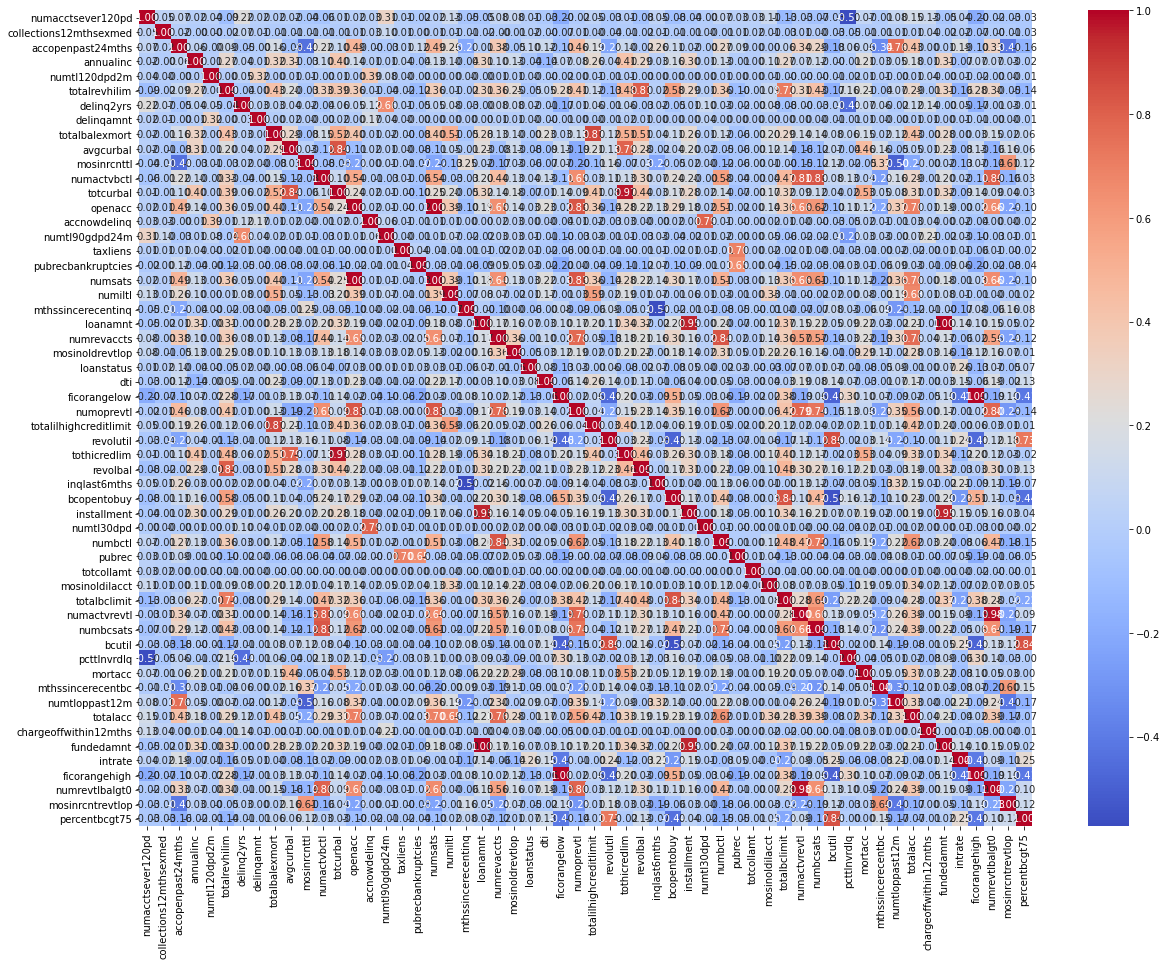

In [46]:
fig, ax = plt.subplots(figsize = (20,15))
cm_df = sns.heatmap(hst_drop_df[num_feature_list].corr(), annot = True, fmt = ".2f", cmap = 'coolwarm', ax = ax)

In [49]:
# Create correlation matrix
corr_matrix = hst_drop_df[num_feature_list].corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
upper_list = upper.stack()
upper_list[(upper_list>0.95)|(upper_list<-0.95)]

totcurbal     tothicredlim      0.972805
openacc       numsats           0.998729
loanamnt      installment       0.953435
              fundedamnt        0.999545
ficorangelow  ficorangehigh     1.000000
installment   fundedamnt        0.954105
numactvrevtl  numrevtlbalgt0    0.982028
dtype: float64

In [50]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
[x for x in to_drop]

['numsats',
 'tothicredlim',
 'installment',
 'fundedamnt',
 'ficorangehigh',
 'numrevtlbalgt0']

Based on the correlation analysis, the above features are highly correlated. I'll keep them now and may drop them before model training.

### 3.4 Plot The Statistics of Features <a name="Plot The Statistics of Features"></a>

In [51]:
# make general plots to examine the features
def plot_var(df, col_name, full_name, continuous, log):
    """
    -col_name is the variable name in the dataframe
    -full_name is the full variable name
    -continuous
    """ 
    tmp = df[[col_name,'loanstatus']]
    target = {0: 'Fully Paid',
             1: 'Charged Off'}
    tmp.loanstatus = tmp.loanstatus.map(target)
    
    if log:
        tmp[col_name] = tmp[col_name].apply(lambda x: np.log10(x+1)) 
    fig, (ax1, ax2) = plt.subplots(1,2,sharex = False, figsize = (15,3))
    #plot 1: counts distribution of the variable
    sns.set_style("whitegrid")
    if continuous:
        sns.distplot(tmp.loc[tmp[col_name].notnull(),col_name], kde=False, ax=ax1)
    else:
        sns.countplot(tmp[col_name],order=sorted(tmp[col_name][tmp[col_name].notnull()].unique()), color = '#5975A4',saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    ax1.grid(True)
    
    #plot 2: bar plot of the variable grouped by loan status
    sns.set_style("whitegrid")
    if continuous:
        sns.boxplot(x=col_name, y='loanstatus', data=tmp, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name+' by Loan Status')
    else:
        charged_off_rates = tmp.groupby(col_name)['loanstatus'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)
        sns.barplot(x=charged_off_rates.index, y=charged_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fronciton of loans charged off')
        ax2.set_title('Charged off rate by '+full_name)
        ax2.set_xlabel(full_name)
    ax2.xaxis.grid(True)
    
    #plot 3: kde plot of the variable grouped by loan status
    if continuous:
        sns.set_style("whitegrid")
        facet = sns.FacetGrid(tmp, hue='loanstatus', size=3,aspect=4)
        facet.map(sns.kdeplot,col_name, shade=True)
        #facet.set(xlim=(tmp[col_name].min(), tmp[col_name].max()))
        facet.add_legend()
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loanstatus', data=tmp, order=sorted(tmp[col_name][tmp[col_name].notnull()].unique()))

    
    plt.tight_layout()

### annual income
The self-reported annual income provided by the borrower during registration.

In [54]:
hst_drop_df.annualinc.describe()

count    1.348095e+06
mean     7.623774e+04
std      6.992274e+04
min      0.000000e+00
25%      4.575000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annualinc, dtype: float64

Annual income ranges from \$0 to \$8M, with a median at \$65k, which doubles the national median individual income in the US (\$40k for males and \$25k for females). Due to the large range of variation, we log-transform the values.

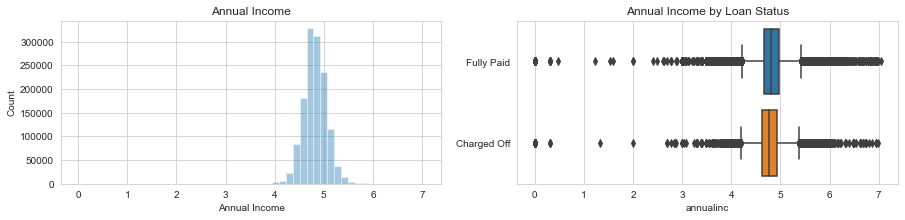

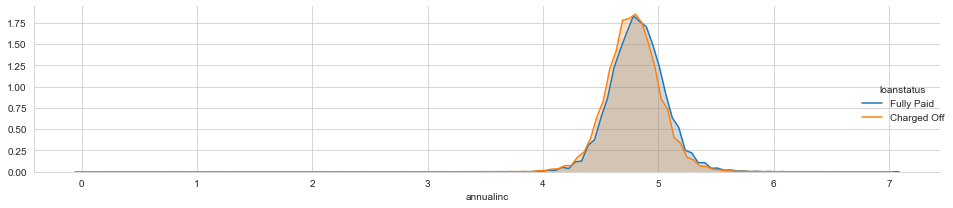

In [55]:
plot_var(hst_drop_df,'annualinc', 'Annual Income', continuous=True, log = True)

The plots indicates that the annual income in the fully paid group is slightly higher than the one in the charged off group

### dti
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [57]:
hst_drop_df.dti.describe()

count    1.347725e+06
mean     1.827425e+01
std      1.115549e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.405000e+01
max      9.990000e+02
Name: dti, dtype: float64

The 75% quantile value is 24, while the max is 999, thus we limit the effective value to <60 for QC purpose

In [58]:
hst_drop_df1 = hst_drop_df[hst_drop_df['dti']<60]

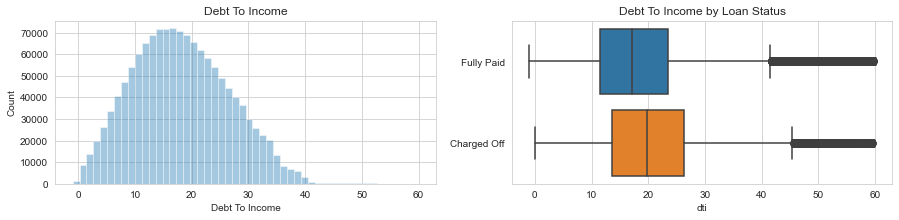

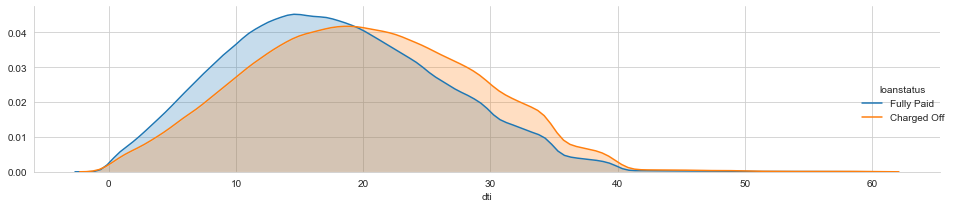

In [59]:
plot_var(hst_drop_df1,'dti', 'Debt To Income', continuous=True, log = False)

The charged off group generally have higher dti

### ficorangehigh
Data Dictionary: The upper boundary range the borrower’s FICO at loan origination belongs to.

In [60]:
hst_drop_df.ficorangehigh.describe()

count    1.348099e+06
mean     7.001624e+02
std      3.185143e+01
min      6.140000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: ficorangehigh, dtype: float64

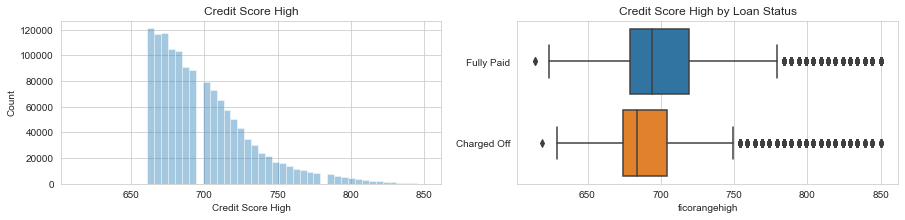

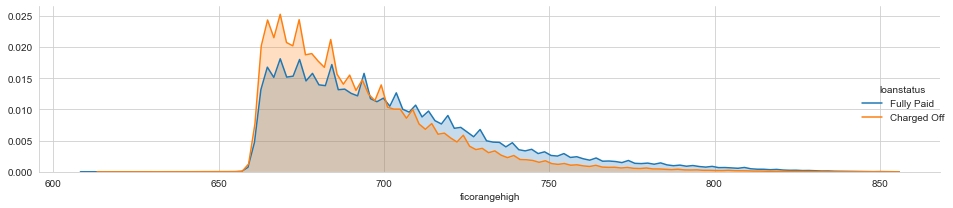

In [61]:
plot_var(hst_drop_df1,'ficorangehigh', 'Credit Score High', continuous=True, log = False)

The charged off group have credit score upper boundary more skewed to the lower scores

### intrate
Interest Rate on the loan

In [62]:
hst_drop_df.intrate.describe()

count    1.348099e+06
mean     1.324156e+01
std      4.765685e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: intrate, dtype: float64

The lowest interest rate is 5.31%, the highest interest rate is 31.0%, and the mean is about 13.2%

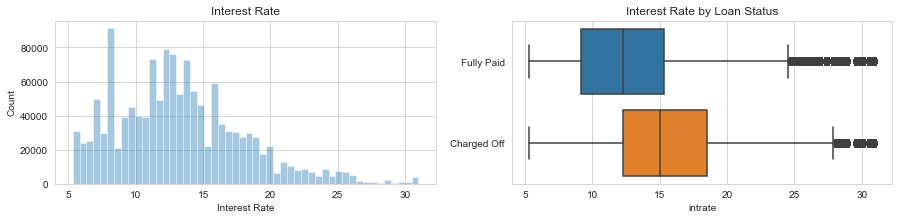

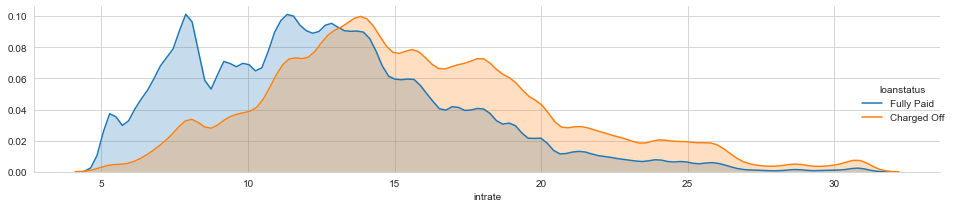

In [63]:
plot_var(hst_drop_df1,'intrate', 'Interest Rate', continuous=True, log = False)

Interest rate looked quite different between the full-paid and charged-off group

### Loan amount
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

hst_drop_df.loanamnt.describe()

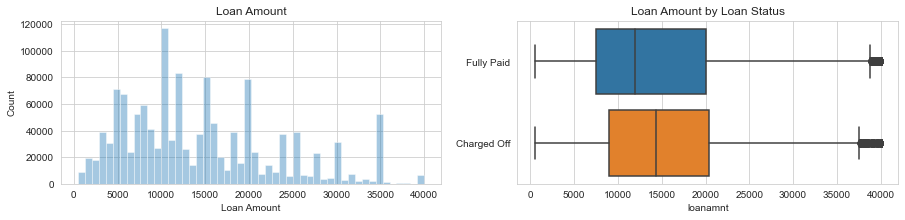

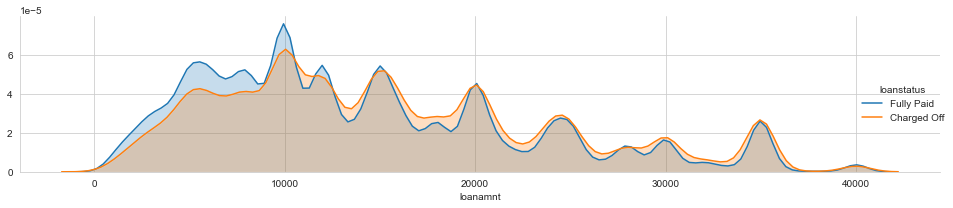

In [66]:
plot_var(hst_drop_df, 'loanamnt', 'Loan Amount', continuous=True, log = False)

The charged-off grouop generally borrowed more

### numactvbctl
data dictionary: Number of currently active bankcard accounts

In [67]:
hst_drop_df.numactvbctl.describe()

count    1.277823e+06
mean     3.642732e+00
std      2.248260e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      3.500000e+01
Name: numactvbctl, dtype: float64

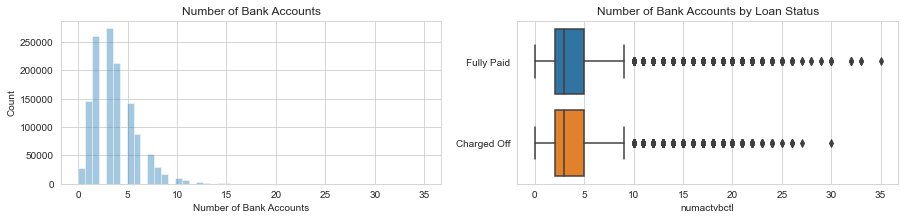

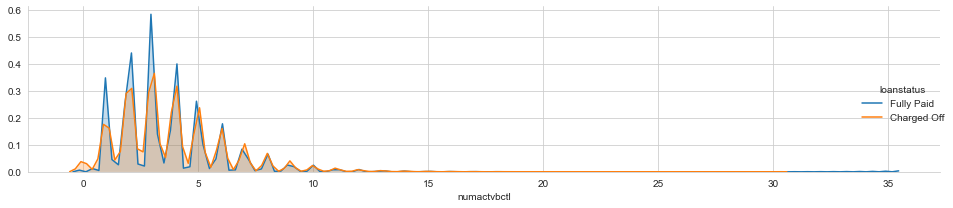

In [68]:
plot_var(hst_drop_df, 'numactvbctl', 'Number of Bank Accounts', continuous=True, log = False)

There difference is not very observable

### pcttlnvrdlq
Percent of trades never delinquent

In [69]:
hst_drop_df.pcttlnvrdlq.describe()

count    1.277669e+06
mean     9.416469e+01
std      8.744087e+00
min      0.000000e+00
25%      9.130000e+01
50%      9.800000e+01
75%      1.000000e+02
max      1.000000e+02
Name: pcttlnvrdlq, dtype: float64

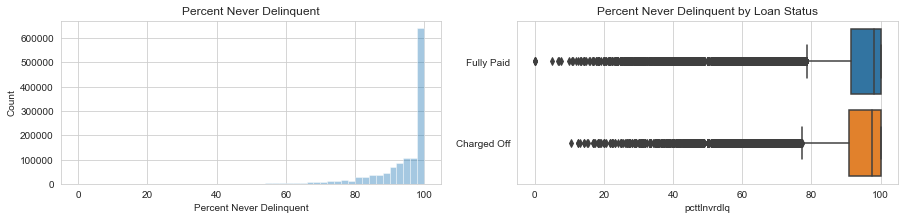

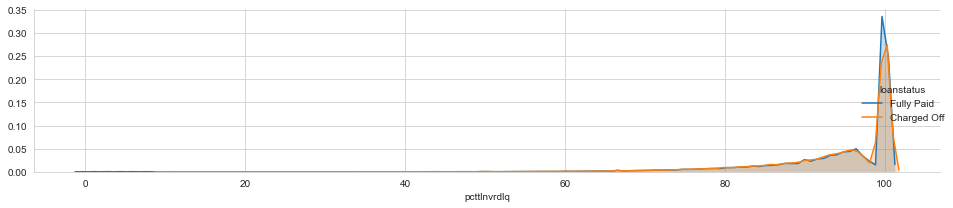

In [70]:
plot_var(hst_drop_df, 'pcttlnvrdlq', 'Percent Never Delinquent', continuous=True, log = False)

Most applicant did not have deliquent trades

### pubrec
Number of derogatory public records

In [71]:
hst_drop_df.pubrec.describe()

count    1.348070e+06
mean     2.150497e-01
std      6.014718e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pubrec, dtype: float64

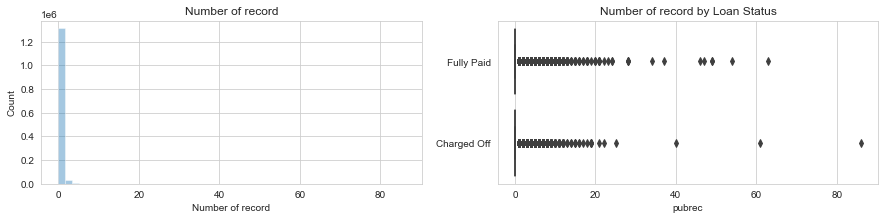

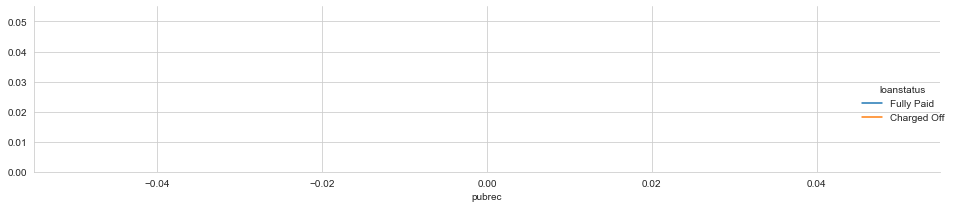

In [72]:
plot_var(hst_drop_df, 'pubrec', 'Number of record', continuous=True, log = False)

The public derogatory records happened rarely

### totalbclimit
Total bankcard high credit/credit limit

In [73]:
hst_drop_df.totalbclimit.describe()

count    1.298069e+06
mean     2.163393e+04
std      2.155464e+04
min      0.000000e+00
25%      7.800000e+03
50%      1.510000e+04
75%      2.810000e+04
max      1.105500e+06
Name: totalbclimit, dtype: float64

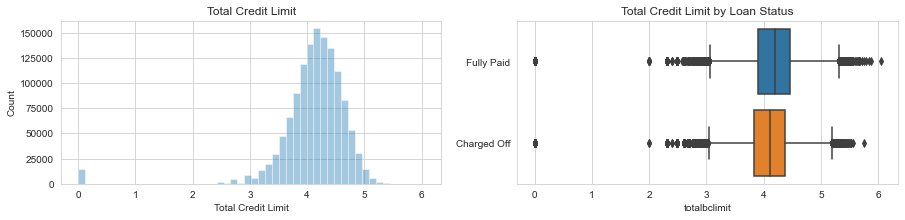

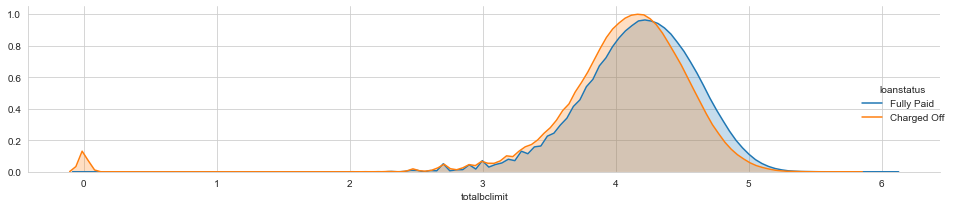

In [74]:
plot_var(hst_drop_df, 'totalbclimit', 'Total Credit Limit', continuous=True, log = True)

The credit limit in the charged-off group is slightly lower

### addrstate
The state provided by the borrower in the loan application

In [76]:
hst_drop_df.addrstate.value_counts()

CA    196853
TX    110354
NY    110097
FL     95843
IL     51870
NJ     48583
PA     45656
OH     43947
GA     43480
VA     38119
NC     37826
MI     35308
AZ     32748
MD     31298
MA     31071
CO     29736
WA     29235
MN     24004
IN     21726
MO     21340
TN     20400
NV     20296
CT     19791
WI     17788
AL     16645
OR     16427
SC     16010
LA     15524
KY     12871
OK     12298
KS     11267
AR     10062
UT     10055
NM      7377
HI      6765
MS      6595
NH      6465
RI      5881
WV      4888
MT      3834
DE      3805
NE      3592
DC      3485
AK      3195
WY      2926
SD      2770
VT      2655
ME      2030
ID      1692
ND      1602
IA        14
Name: addrstate, dtype: int64

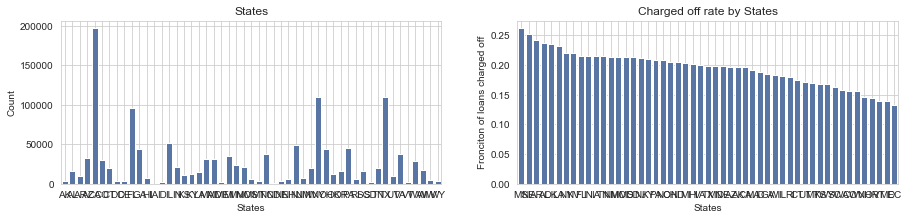

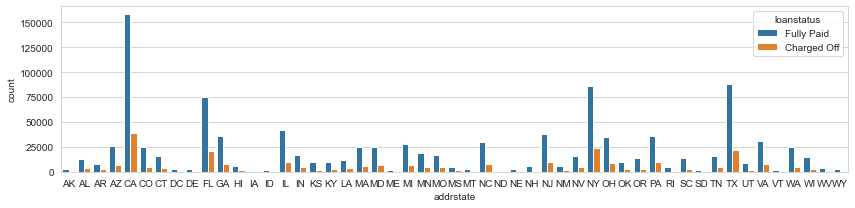

In [77]:
plot_var(hst_drop_df, 'addrstate', 'States', continuous=False, log = False)

In [78]:
charged_off_rates = hst_drop_df.groupby('addrstate')['loanstatus'].value_counts(normalize=True)[:,1].sort_values(ascending=False)
charged_off_rates

addrstate
MS    0.261107
NE    0.252227
AR    0.241105
AL    0.236347
OK    0.234672
LA    0.231770
NY    0.220506
NV    0.219698
FL    0.215018
IN    0.214305
IA    0.214286
TN    0.214118
NM    0.213637
MO    0.213402
MD    0.213368
SD    0.213357
NJ    0.211185
KY    0.210085
PA    0.208297
NC    0.207952
OH    0.205247
ND    0.204744
MI    0.203070
HI    0.202217
VA    0.199428
TX    0.198425
MN    0.197592
DE    0.197372
AZ    0.196592
AK    0.196557
CA    0.196299
MA    0.190724
ID    0.187943
GA    0.184292
WI    0.183719
IL    0.181203
RI    0.178881
CT    0.173867
UT    0.170761
MT    0.169797
KS    0.167569
WY    0.167464
SC    0.162898
WA    0.157893
CO    0.155367
WV    0.155278
NH    0.145708
OR    0.144275
VT    0.139736
ME    0.138424
DC    0.132281
Name: loanstatus, dtype: float64

The state with highest charged off rate is MS at 26.1%, while the lowest charged off rate for one state is 13.2% found in DC 

### applicationtype
Indicates whether the loan is an individual application or a joint application with two co-borrowers

In [79]:
hst_drop_df.applicationtype.value_counts()

Individual    1322293
Joint App       25806
Name: applicationtype, dtype: int64

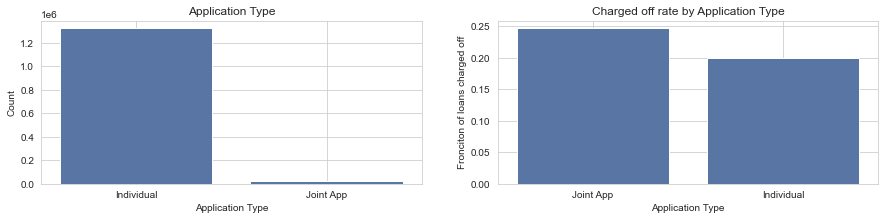

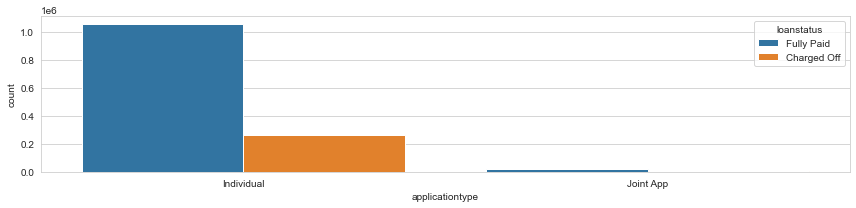

In [80]:
plot_var(hst_drop_df, 'applicationtype', 'Application Type', continuous=False, log = False)

The joint app had higher charged-off rate. Interesting!

### earliestcrline & lastcreditpulld
The date the borrower's earliest reported credit line was opened <br>
The date LC pulled credit for this loan<br>
The difference between these two features indicates the credit history before the loan application. Thus, I am going to combine these two features to create a new credithistory feature

In [81]:
dttoday = datetime.now().strftime('%Y-%m-%d')
hst_drop_df.earliestcrline = pd.to_datetime(hst_drop_df.earliestcrline)
hst_drop_df.lastcreditpulld= pd.to_datetime(hst_drop_df.lastcreditpulld)

In [82]:
hst_drop_df.earliestcrline = hst_drop_df.earliestcrline.loc[hst_drop_df.earliestcrline.notnull()].apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)
hst_drop_df.lastcreditpulld = hst_drop_df.lastcreditpulld.loc[hst_drop_df.lastcreditpulld.notnull()].apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

In [86]:
#combine the earliestcrline and lastcreditpulled to create a new feature:credit history
hst_drop_df['credithistory'] = hst_drop_df.earliestcrline - hst_drop_df.lastcreditpulld

In [87]:
hst_drop_df.credithistory.describe()

count    1.348014e+06
mean     1.919151e+01
std      7.646597e+00
min      1.336986e+00
25%      1.392603e+01
50%      1.784384e+01
75%      2.317808e+01
max      8.464384e+01
dtype: float64

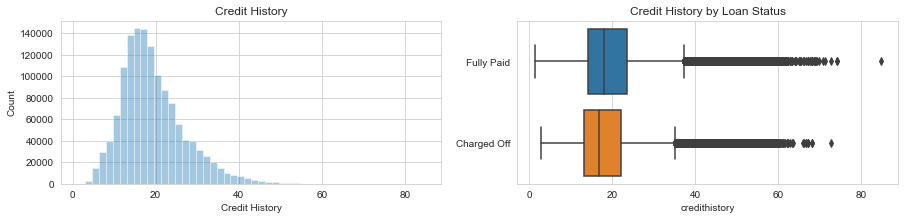

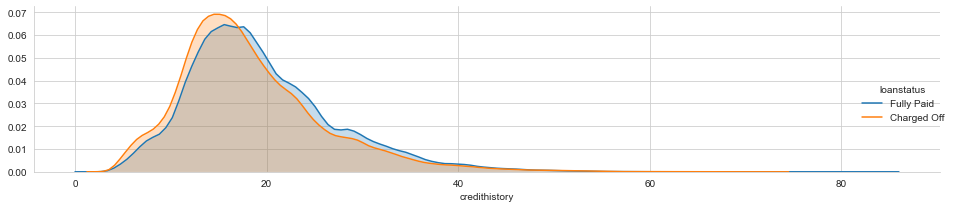

In [88]:
plot_var(hst_drop_df, 'credithistory', 'Credit History', continuous=True, log = False)

The paid-off group had slightly larger average credit history

### emplength

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [89]:
hst_drop_df.emplength.describe()

count       1269549
unique           11
top       10+ years
freq         442679
Name: emplength, dtype: object

In [192]:
hst_drop_df.emplength.value_counts()

AttributeError: 'DataFrame' object has no attribute 'emplength'

In [90]:
hst_drop_df['emplength'].replace('10+ years', '10 years', inplace=True)
hst_drop_df['emplength'].replace('0years', '0 years', inplace=True)

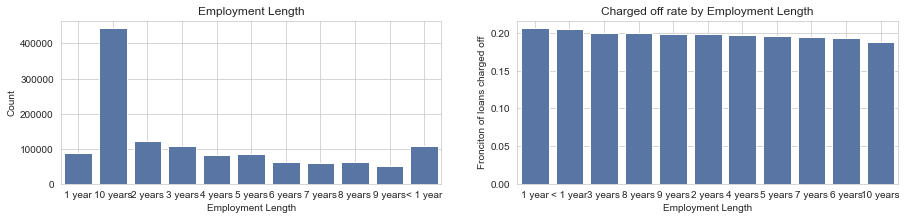

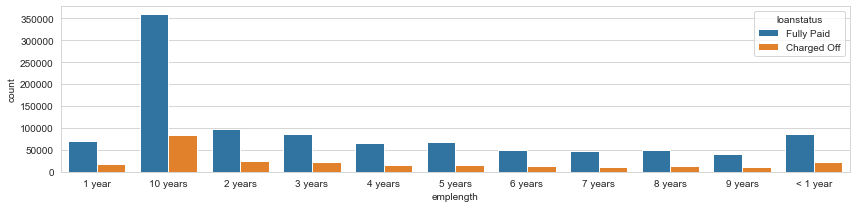

In [91]:
plot_var(hst_drop_df, 'emplength', 'Employment Length', continuous=False, log = False)

The more charged-off rate in shorter credit history

### grade
LC assigned loan grade

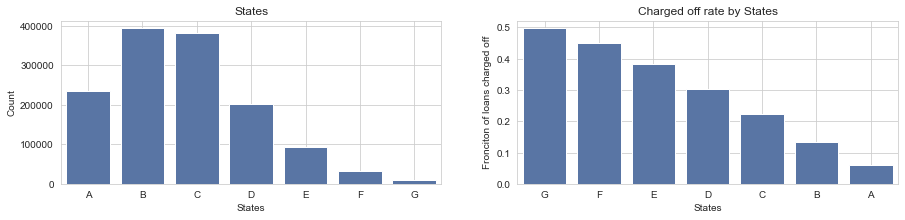

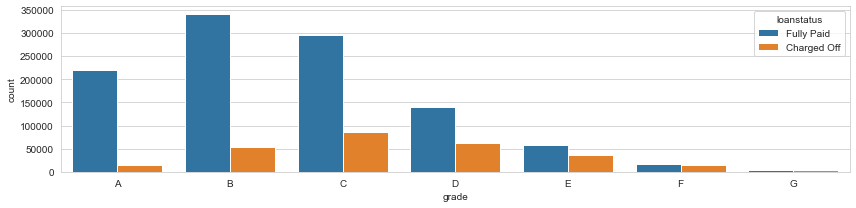

In [92]:
plot_var(hst_drop_df, 'grade', 'States', continuous=False, log = False)

grade is strongly related to the charged-off rate

### homeownership
The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [93]:
hst_drop_df.homeownership.value_counts()

MORTGAGE    666852
RENT        535699
OWN         145027
ANY            286
OTHER          182
NONE            53
Name: homeownership, dtype: int64

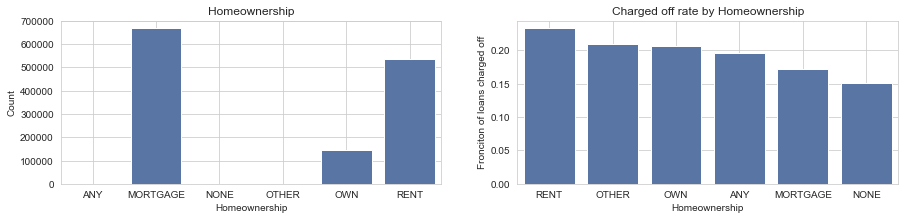

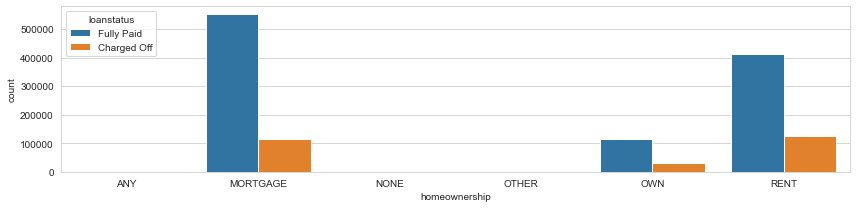

In [94]:
plot_var(hst_drop_df, 'homeownership', 'Homeownership', continuous=False, log = False)


the charged off rate in the rent category is high

### purpose
A category provided by the borrower for the loan request. 

In [95]:
hst_drop_df.purpose.value_counts()

debt_consolidation    781442
credit_card           295625
home_improvement       87721
other                  78301
major_purchase         29550
medical                15614
small_business         15577
car                    14652
moving                  9526
vacation                9084
house                   7298
wedding                 2350
renewable_energy         936
educational              423
Name: purpose, dtype: int64

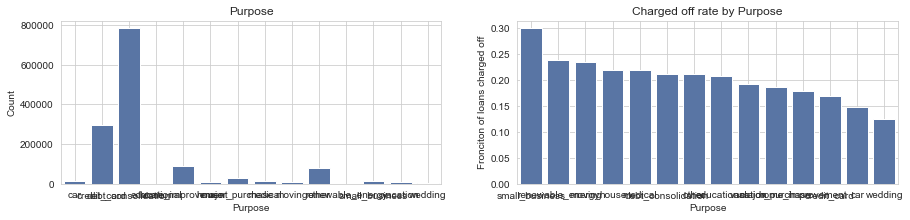

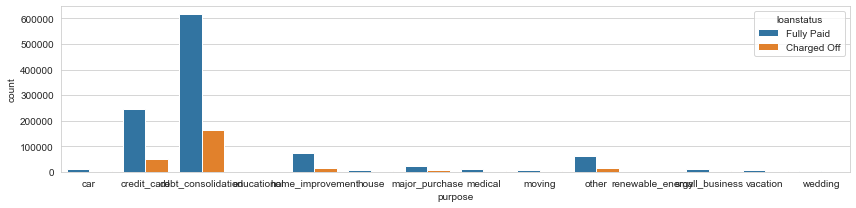

In [96]:
plot_var(hst_drop_df, 'purpose', 'Purpose', continuous=False, log = False)

small business has relatively higher charged-off rate

### verificationstatus
Indicates if income is verified by LC

In [97]:
hst_drop_df.verificationstatus.value_counts()

Source Verified    521579
Verified           418979
Not Verified       407541
Name: verificationstatus, dtype: int64

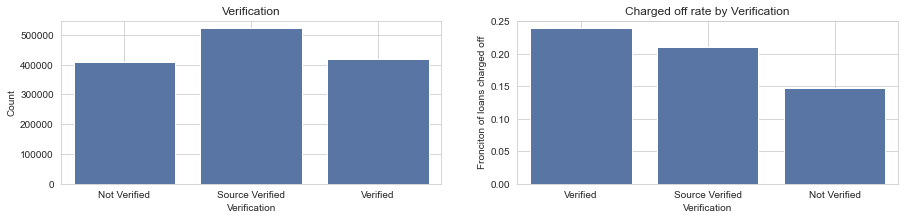

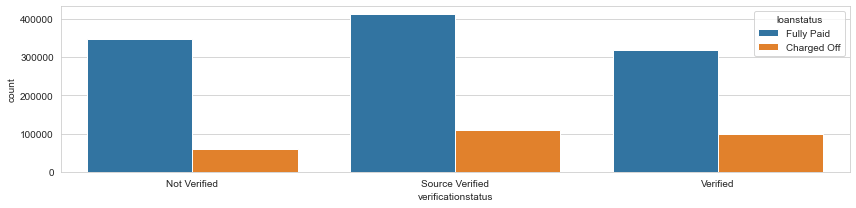

In [98]:
plot_var(hst_drop_df, 'verificationstatus', 'Verification', continuous=False, log = False)


This is a surprise that the notes with income verified by LC had higher charged-off rate

In [100]:
drop_features = ['accnowdelinq','delinqamnt','chargeoffwithin12mths','numsats','tothicredlim','installment','fundedamnt','ficorangehigh','numrevtlbalgt0','zipcode','id','emptitle','earliestcrline','lastcreditpulld']
hst_drop_df.drop(drop_features, axis=1, inplace=True)

In [102]:
hst_drop_df.shape

(1348099, 58)

### Summary
Dropped Features:<br>
'accnowdelinq','delinqamnt','chargeoffwithin12mths': Large P values <br>
'numsats','tothicredlim','installment','fundedamnt','ficorangehigh','numrevtlbalgt0': Highly correlated <br>
'zipcode': to many category values. It will be dropped now. But it can be added by relating other information, such as zipcode average income <br>
'id': not useful<br>
'emptitle': drop now, but it can be added after NLP <br>
'earliestcrline','lastcreditpulld': combined as credithistory

## 4. Feature Engineering <a name="Feature Engineering"></a>
 The following features need label encoding or dummy encoding:
 * 'addrstate',
 'applicationtype',
 'emplength',
 'grade',
 'homeownership',
 'initialliststatus',
 'purpose',
 'subgrade',
 'term',
 'verificationstatus'

### 4.1 Label Encoding <a name="Label Encoding"></a>

In [103]:
#grade and subgrade use label encoding because the rank matters
grade_dic = {"A":1,
            "B":2,
            "C":3,
            "D":4,
            "E":5,
            "F":6,
            "G":7}
hst_drop_df.grade = hst_drop_df.grade.map(grade_dic)
hst_drop_df.subgrade = hst_drop_df.subgrade.apply(lambda x:(grade_dic[x[0]]-1)*5+int(x[1]))

In [104]:
hst_drop_df[['grade','subgrade']].head()

grade  subgrade
0      3        14
1      3        11
2      2         9
4      6        26
5      3        13

In [ ]:
#emplength use label encoding because the rank matters

### 4.2 One-hot Encoding <a name="One-hot Encoding"></a>

In [105]:
dummy_list = ['addrstate', 'applicationtype', 'emplength',  'homeownership', 'initialliststatus', 'purpose',  'term', 'verificationstatus']
for f in dummy_list:
    dummy_df = pd.get_dummies(hst_drop_df[f], prefix = f)
    hst_drop_df = hst_drop_df.drop([f], axis=1)
    hst_drop_df = pd.concat((hst_drop_df, dummy_df), axis = 1)

In [106]:
hst_drop_df.shape

(1348099, 141)

In [107]:
output = 'hst_drop_df0705.pkl'
hst_drop_df.to_pickle(file_path+output)

### 4.3 Train/Test data split <a name="Train/Test data split"></a>

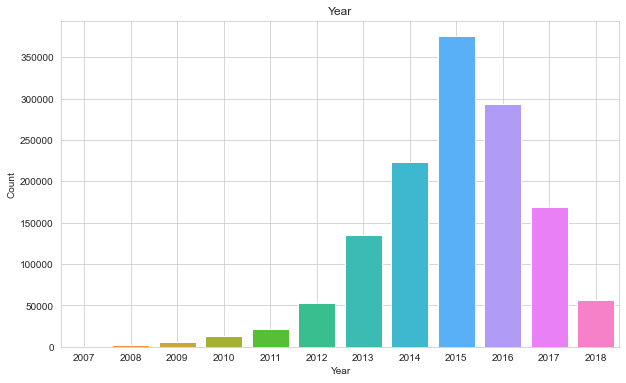

In [108]:
hst_drop_df = pd.concat([hst_drop_df, hst_df.issued], axis=1)
hst_drop_df['issued'] = pd.to_datetime(hst_drop_df['issued'])
fig, ax = plt.subplots(1,1,sharex = False, figsize = (10,6))    
sns.countplot(hst_drop_df['issued'].dt.year,order=sorted(hst_drop_df['issued'][hst_drop_df['issued'].notnull()].dt.year.unique()),saturation=1)
#color = '#5975A4'
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Year')
ax.grid(True)

#Since 2013, the loan number increased drastically until it reached the peak in year 2015. From 2015, the loan business declined through the following years

In [109]:
#I'll split the train/test sample at 8:2
df_train = hst_drop_df.loc[hst_drop_df['issued']<hst_drop_df['issued'].quantile(0.8)]
df_test = hst_drop_df.loc[hst_drop_df['issued']>hst_drop_df['issued'].quantile(0.8)]

In [110]:
df_train.drop('issued', axis=1, inplace = True)

In [115]:
df_test.drop('issued', axis=1, inplace = True)

In [118]:
X_train = df_train.drop(['loanstatus'], axis=1)
Y_train = df_train.loc[:,'loanstatus']
X_test = df_test.drop(['loanstatus'], axis=1)
Y_test = df_test.loc[:,'loanstatus']

### 4.4 Imputing missing value <a name="Imputing missing value"></a>
Use median value to fill the Null values in both train and test data 

In [113]:
#check the missing value fraction after dropping the features with 50% or more missing values
missing_values_table(X_train)

Your selected dataframe has 140 columns.
There are 43 column that have missing values.


Missing Values  % of Total Values     Type
mthssincerecentinq              151340               14.2  float64
numtl120dpd2m                   106973               10.0  float64
mosinoldilacct                  100775                9.5  float64
pcttlnvrdlq                      70429                6.6  float64
avgcurbal                        70288                6.6  float64
mosinrcntrevtlop                 70277                6.6  float64
mosinoldrevtlop                  70277                6.6  float64
numrevaccts                      70277                6.6  float64
numacctsever120pd                70276                6.6  float64
numiltl                          70276                6.6  float64
numtloppast12m                   70276                6.6  float64
numactvrevtl                     70276                6.6  float64
totcollamt                       70276                6.6  float64
numbctl                          70276                6.6  float64
numtl30dpd                       70276                6.6  float64
totalilhighcreditlimit           70276                6.6  float64
numoprevtl                       70276                6.6  float64
numtl90gdpd24m                   70276                6.6  float64
totalrevhilim                    70276                6.6  float64
totcurbal                        70276                6.6  float64
numactvbctl                      70276                6.6  float64
mosinrcnttl                      70276                6.6  float64
bcutil                           60543                5.7  float64
percentbcgt75                    60342                5.7  float64
bcopentobuy                      59938                5.6  float64
mthssincerecentbc                59246                5.6  float64
numbcsats                        58590                5.5  float64
totalbalexmort                   50030                4.7  float64
totalbclimit                     50030                4.7  float64
accopenpast24mths                50030                4.7  float64
mortacc                          50030                4.7  float64
pubrecbankruptcies                1365                0.1  float64
revolutil                          621                0.1  float64
collections12mthsexmed             145                0.0  float64
taxliens                           105                0.0  float64
credithistory                       79                0.0  float64
inqlast6mths                        30                0.0  float64
delinq2yrs                          29                0.0  float64
pubrec                              29                0.0  float64
openacc                             29                0.0  float64
totalacc                            29                0.0  float64
dti                                 27                0.0  float64
annualinc                            4                0.0  float64

In [119]:
imputer = Imputer(strategy = 'median')
imputer.fit(X_train)
X_train = pd.DataFrame(imputer.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

In [120]:
missing_values_table(X_train)

Your selected dataframe has 140 columns.
There are 0 column that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values, Type]
Index: []

In [121]:
missing_values_table(X_test)

Your selected dataframe has 140 columns.
There are 0 column that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values, Type]
Index: []

The missing value has all be filled with median value

### 4.5 Feature Scaling <a name="Feature Scaling"></a>

In [122]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [123]:
X_train_scl = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scl = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 5. Modeling <a name="Modeling"></a>

### 5.1 Linear logistic regression with SGD <a name="Linear logistic regression with SGD"></a>

In [125]:
pipeline_sgdlr = Pipeline([
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=101, warm_start=False))
])
param_grid_sgdlr  = {
    'model__alpha': [10**-5, 10**-1, 10**2],
    'model__penalty': ['l1', 'l2']
}

In [126]:
kfold = 3
grid_sgdlr = GridSearchCV(estimator=pipeline_sgdlr, param_grid=param_grid_sgdlr, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [127]:
grid_sgdlr2 = GridSearchCV(estimator=pipeline_sgdlr, param_grid=param_grid_sgdlr, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

grid_sgdlr2.fit(X_train_scl,Y_train)

clf_sgdlr_gs2 = grid_sgdlr2.best_estimator_
print('Best score: ', grid_sgdlr2.best_score_)
print('Best parameter set: \n', grid_sgdlr2.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.0min finished


Best score:  0.7175517497314524
Best parameter set: 
 {'model__alpha': 0.1, 'model__penalty': 'l2'}


In [128]:
pred_sgdlr_gs_train2 =  clf_sgdlr_gs2.predict(X_train_scl)
auc_sgdlr_gs_train2 = roc_auc_score(pred_sgdlr_gs_train2, Y_train)
print(auc_sgdlr_gs_train2)

0.6946316821187867


In [129]:
pred_sgdlr_gs_test2 =  clf_sgdlr_gs2.predict(X_test_scl)
auc_sgdlr_gs_test2 = roc_auc_score(pred_sgdlr_gs_test2, Y_test)
print(auc_sgdlr_gs_test2)

0.6565675149175737


### Recursive Feature Elimination (RFE)

In [132]:
clf_sgdlr3 = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=101, warm_start=False, alpha=0.1, penalty='l2')
clf_sgdlr3.fit(X_train_scl, Y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=101, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [134]:
rfe_sgdlr3 = RFE(clf_sgdlr3, n_features_to_select = 1)
rfe_sgdlr3.fit(X_train_scl, Y_train)

RFE(estimator=SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=101, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [135]:
tmp = sorted(zip(map(lambda x: round(x,4), rfe_sgdlr3.ranking_), X_train_scl.columns))
rank = [x for x,_ in tmp]
feature = [x for _,x in tmp]
print("Logistic regression RFE result: Top 10")
pd.DataFrame({'rank':rank}, index = feature).head(10)

Logistic regression RFE result: Top 10


rank
subgrade              1
grade                 2
intrate               3
term_ 60 months       4
accopenpast24mths     5
ficorangelow          6
term_ 36 months       7
totcurbal             8
dti                   9
mortacc              10

### 5.2 Random Forest <a name="Random Forest"></a>

In [137]:
clf_rf = RandomForestClassifier(n_jobs = -1, n_estimators = 100, random_state = 102, max_features = 'sqrt')

In [165]:
#grid search
param_grid_rf = {
    'n_estimators':[100,200],
    'criterion':['gini', 'entropy'],
    'class_weight':[{0:1, 1:1},{0:1, 1:2}],
    'max_depth':[10,15],
    'min_samples_split':[2,4]
}

In [166]:
grid_rf = GridSearchCV(estimator = clf_rf, param_grid = param_grid_rf, scoring = 'roc_auc', n_jobs = -1, pre_dispatch = '2*n_jobs', cv = kfold, verbose=1, return_train_score = True)

In [167]:
grid_rf.fit(X_train_scl,Y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 89.6min


KeyboardInterrupt: 

In [169]:
clf_rf2 = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = 100, 
                                 random_state = 102, 
                                 max_depth= 10,
                                 max_features = 'sqrt',
                                )

In [170]:
start = time.time()
print('training...')
clf_rf2.fit(X_train_scl,Y_train)
print('training finishied in %d seconds...' % (time.time()-start))

training...
training finishied in 124 seconds...


In [171]:
pred_rf2_train =  clf_rf2.predict(X_train_scl)
auc_rf2_train = roc_auc_score(pred_rf2_train, Y_train)
print(auc_rf2_train)

0.7630316942820407


In [172]:
pred_rf2_test =  clf_rf2.predict(X_test_scl)
auc_rf2_test = roc_auc_score(pred_rf2_test, Y_test)
print(auc_rf2_test)

0.6862588493369273


In [204]:
clf_rf2.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Feature Importance

In [180]:
clf_rf2.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [181]:
feature_importances_rf = pd.DataFrame(clf_rf2.feature_importances_,
                                     index = X_train_scl.columns,
                                     columns = ['importance']).sort_values('importance',ascending=False)

In [182]:
print("Features sorted by their score: Top 10")
feature_importances_rf.head(10)

Features sorted by their score: Top 10


importance
subgrade             0.168327
grade                0.137700
intrate              0.131568
term_ 36 months      0.097889
term_ 60 months      0.097771
ficorangelow         0.028763
dti                  0.028421
accopenpast24mths    0.025764
credithistory        0.019482
avgcurbal            0.018217

### 5.3 Gradient Boosting Tree  <a name="Gradient Boosting Tree"></a>

In [194]:
[x for x in X_train_scl]

['numacctsever120pd',
 'collections12mthsexmed',
 'accopenpast24mths',
 'annualinc',
 'numtl120dpd2m',
 'totalrevhilim',
 'delinq2yrs',
 'totalbalexmort',
 'avgcurbal',
 'mosinrcnttl',
 'numactvbctl',
 'totcurbal',
 'openacc',
 'numtl90gdpd24m',
 'taxliens',
 'pubrecbankruptcies',
 'numiltl',
 'grade',
 'mthssincerecentinq',
 'loanamnt',
 'numrevaccts',
 'mosinoldrevtlop',
 'dti',
 'ficorangelow',
 'numoprevtl',
 'totalilhighcreditlimit',
 'revolutil',
 'revolbal',
 'inqlast6mths',
 'bcopentobuy',
 'numtl30dpd',
 'numbctl',
 'pubrec',
 'totcollamt',
 'mosinoldilacct',
 'totalbclimit',
 'numactvrevtl',
 'numbcsats',
 'bcutil',
 'pcttlnvrdlq',
 'mortacc',
 'mthssincerecentbc',
 'numtloppast12m',
 'totalacc',
 'intrate',
 'subgrade',
 'mosinrcntrevtlop',
 'percentbcgt75',
 'credithistory',
 'addrstate_AK',
 'addrstate_AL',
 'addrstate_AR',
 'addrstate_AZ',
 'addrstate_CA',
 'addrstate_CO',
 'addrstate_CT',
 'addrstate_DC',
 'addrstate_DE',
 'addrstate_FL',
 'addrstate_GA',
 'addrstate_HI'

In [193]:
X_train_scl = X_train_scl.rename({'emplength_< 1 year': 'emplength_0 year'}, axis=1)

In [195]:
dtrain = xgb.DMatrix(X_train_scl,Y_train, missing = np.NaN)

In [197]:
clf_gbt = xgb.XGBClassifier(nthread=-1, learning_rate = 0.02, n_estimators=1000,max_depth=8, subsample = 0.9, min_child_weight=4)
#     pipeline = make_pipeline(StandardScaler(), LogisticRegression(n_jobs=n_jobs))
start = time.time()
print('training...')
clf_gbt.fit(X_train_scl,Y_train)
print('training finishied in %d seconds...' % (time.time()-start))

training...
training finishied in 19208 seconds...


In [199]:
import pickle
filename = 'clf_gbt_0706.sav'
pickle.dump(clf_gbt, open(filename, 'wb'))

In [200]:
pred_gbt_train =  clf_gbt.predict(X_train_scl)
auc_gbt_train = roc_auc_score(pred_gbt_train, Y_train)
print(auc_gbt_train)

0.7783153467348354


In [203]:
X_test_scl = X_test_scl.rename({'emplength_< 1 year': 'emplength_0 year'}, axis=1)
pred_gbt_test =  clf_gbt.predict(X_test_scl)
auc_gbt_test = roc_auc_score(pred_gbt_test, Y_test)
print(auc_gbt_test)

0.6591932982153054


In [205]:
clf_gbt.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.02,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 4,
 'missing': None,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.9}

In [206]:
feature_importances_gbt = pd.DataFrame(clf_gbt.feature_importances_,
                                     index = X_train_scl.columns,
                                     columns = ['importance']).sort_values('importance',ascending=False)

In [207]:
print("Features sorted by their score: Top 10")
feature_importances_gbt.head(10)

Features sorted by their score: Top 10


importance
credithistory      0.101854
mosinoldrevtlop    0.073039
mosinoldilacct     0.051138
dti                0.045329
annualinc          0.042021
loanamnt           0.038239
avgcurbal          0.031184
intrate            0.029794
revolbal           0.027767
revolutil          0.026138

### 6. Model Comparison  <a name="Model Comparison"></a>

AUROC                Algorithm
0  0.656568  SGD Logistic Regression
1  0.686259             RandomForest
2  0.659193   Gradiant Boosting Tree

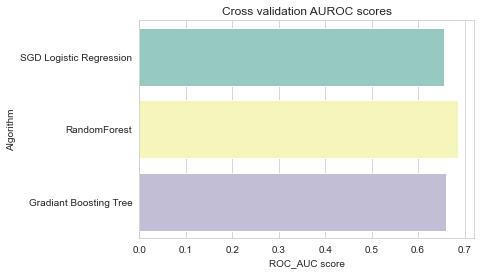

In [209]:
# plot the AUROC scores on the test dataset. 
auroc_means = [auc_sgdlr_gs_test2, auc_rf2_test,auc_gbt_test]
auroc_res = pd.DataFrame({"AUROC":auroc_means,"Algorithm":["SGD Logistic Regression",
"RandomForest","Gradiant Boosting Tree"]})

g = sns.barplot("AUROC","Algorithm", data = auroc_res, palette="Set3",orient = "h")
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation AUROC scores")
auroc_res

In [210]:
def plot_ROC(X_test, Y_test, Y_prob):
    
    #Y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(Y_test, Y_prob, pos_label=1)
    roc_auc = roc_auc_score(Y_test, Y_prob)
    # These are the points at threshold = 0.1~0.5
    x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
    x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

    fig = plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Area = {:.2f})'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()

In [213]:
prob_sgdlr_gs_test2 = clf_sgdlr_gs2.predict_proba(X_test_scl)[:,1]
prob_rf2_test = clf_rf2.predict_proba(X_test_scl)[:,1]
prob_gbt_test = clf_gbt.predict_proba(X_test_scl)[:,1]

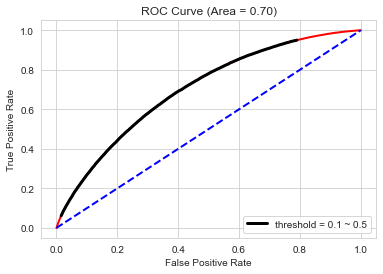

In [218]:
plot_ROC(X_test_scl, Y_test, prob_sgdlr_gs_test2)

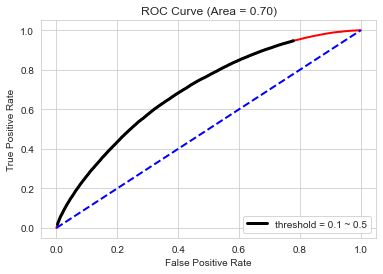

In [217]:
plot_ROC(X_test_scl, Y_test, prob_rf2_test)

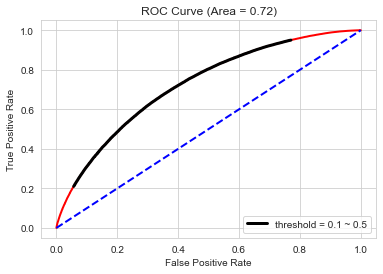

In [220]:
plot_ROC(X_test_scl, Y_test, prob_gbt_test)

In [239]:
space ={
        'n_estimators' : hp.quniform('n_estimators', 50, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth': hp.quniform("x_max_depth", 3, 10, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 2, 6, 1),
        'subsample' : hp.quniform('subsample', 0.7, 1.0, 0.1),
    }

In [230]:
df_X_train1, df_X_val, df_Y_train1, df_Y_val = train_test_split(X_train_scl, Y_train, test_size=0.2, random_state=42)

In [240]:
def objective(space):
    clf = xgb.XGBClassifier(max_depth = int(space['max_depth']),
                            n_estimators = int(space['n_estimators']),
                           learning_rate = float(space['learning_rate']),
                           min_child_weight = int(space['min_child_weight']),
                           subsample = float(space['subsample']),
                           tree_method='gpu_hist', gpu_id=0, nthread=-1)
    eval_set = [(df_X_val,df_Y_val)]
    clf.fit(df_X_train1, df_Y_train1,eval_set=eval_set, 
        eval_metric="auc", early_stopping_rounds=30,verbose=True)

    pred = clf.predict_proba(df_X_train1)[:,1]
    auc = roc_auc_score(df_Y_train1, pred)
    print("SCORE: %s"%(auc))

    return{'loss':1-auc, 'status': STATUS_OK }

In [241]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

[0]	validation_0-auc:0.710425                                                                                                                                                                                 

Will train until validation_0-auc hasn't improved in 30 rounds.                                                                                                                                               

[1]	validation_0-auc:0.715372                                                                                                                                                                                 

[2]	validation_0-auc:0.717818                                                                                                                                                                                 

[3]	validation_0-auc:0.719072                                                                                                                                           

In [242]:
clf_gbt = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, nthread=-1, learning_rate = 0.1, n_estimators=781,max_depth=10, subsample = 0.9, min_child_weight=4)
#     pipeline = make_pipeline(StandardScaler(), LogisticRegression(n_jobs=n_jobs))
start = time.time()
print('training...')
clf_gbt.fit(X_train_scl,Y_train)
print('training finishied in %d seconds...' % (time.time()-start))

training...
training finishied in 259 seconds...


In [243]:
pred_gbt_test =  clf_gbt.predict(X_test_scl)
auc_gbt_test = roc_auc_score(pred_gbt_test, Y_test)
print(auc_gbt_test)

0.6397810926277164


In [245]:
pred_gbt_train =  clf_gbt.predict(X_train_scl)
auc_gbt_train = roc_auc_score(pred_gbt_train, Y_train)
print(auc_gbt_train)

0.9144062111036366
